# Getting Started

---

Getting started with image processing is straightforward. There's three classes of operations in `phenotypic`: `ImageOperation`, `MeasureFeature`, and `ImagePipeline`.

- `ImageOperation`(s): processes that operate on the data of an image in preparation for feature extraction with `MeasureFeature`.
- `MeasureFeature`(s) extract measurements from the objects within the image based on the pixel values.
- `ImagePipeline`(s) are a collection of operations and measurements compiled into a single class for convenience.

To get started with `phenotypic`, it's fastest to start by using one of the pipelines in `phenotypic.prefab`. Below we use `phenotypic.prefab.HeavyWatershedPipeline`, which was used with hand scanner images of *Kluveromyces Marxianus*.

In [1]:
import phenotypic as pht

filepaths = [x for x in
             pht.data.yield_sample_dataset(mode='filepath')]
# This returns the relative filepaths for this sample data
# While unconventional for a loader, this is done to demonstrate importing an directory of images.
filepaths


[PosixPath('../../../../../src/phenotypic/data/PhenoTypicSampleSubset/2_1S_5.jpg'),
 PosixPath('../../../../../src/phenotypic/data/PhenoTypicSampleSubset/2_1S_6.jpg'),
 PosixPath('../../../../../src/phenotypic/data/PhenoTypicSampleSubset/2_1S_7.jpg'),
 PosixPath('../../../../../src/phenotypic/data/PhenoTypicSampleSubset/2_1S_8.jpg'),
 PosixPath('../../../../../src/phenotypic/data/PhenoTypicSampleSubset/3_1S_5.jpg'),
 PosixPath('../../../../../src/phenotypic/data/PhenoTypicSampleSubset/3_1S_6.jpg'),
 PosixPath('../../../../../src/phenotypic/data/PhenoTypicSampleSubset/3_1S_7.jpg'),
 PosixPath('../../../../../src/phenotypic/data/PhenoTypicSampleSubset/3_1S_8.jpg'),
 PosixPath('../../../../../src/phenotypic/data/PhenoTypicSampleSubset/4_1S_5.jpg'),
 PosixPath('../../../../../src/phenotypic/data/PhenoTypicSampleSubset/4_1S_6.jpg'),
 PosixPath('../../../../../src/phenotypic/data/PhenoTypicSampleSubset/4_1S_7.jpg'),
 PosixPath('../../../../../src/phenotypic/data/PhenoTypicSampleSubset/4_1S_8

## Processing your first image

---
Here we're gonna import the last image in the dataset, since its from the last timepoint and should have reasonable growth. Accepted file formats are jpegs, tiffs, pngs, and RAW files.

**Important things to note:**
 - `bit_depth` will have an important role in memory usage and accuracy. For jpe, this will always be 8. For other image formats, consult your camera documentation for information. You may also find this information in your image metadata, depending on the format. PhenoTypic supports bit depths of 8 and 16. If not provided, PhenoTypic will try to guess this information from the imported image data.

In [2]:
# We're gonna import the last image in the dataset, lets make an image with a grid in 96 array format
# Accepted filepaths are jpegs, tiffs, pngs, and RAW format files
# These images are jpegs so we set a bit depth of 8.
image = pht.GridImage.imread(filepaths[-1], nrows=8, ncols=12, bit_depth=8)



Let's then view the image. PhenoTypic uses matplotlib as the backend for compatibility, which allows for streamlined prototyping in Jupyter. All plotting methods return (plt.Figure, plt.Axes) for easy post plotting editing. You can also plot directly to an axes. There's a few different ways to view your image and its internal states.

1. View the input image
``` python
Image.show() # Shows the input image
fig, ax = Image.show() # If you need the figure or axes for further processing
fig.show()
```

2. Viewing specific components
```python
rgb_fig, rgb_ax = Image.rgb.show() # Shows the rgb array if its available
gray_fig, gray_ax = Image.gray.show() # Shows the grayscale array.
```
Also available for other image components such as `enh_gray`, `objmask`, `objmap`, ...

3. Viewing overlay information
```python
overlay_fig, overlay_ax = Image.show_overlay()
overlay_fig.show()
```

/var/folders/78/rnctrlmn5kj996kjnq_mmqlh0000gn/T/ipykernel_84681/4235178448.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()  # Only needed if the plot doesn't automatically show


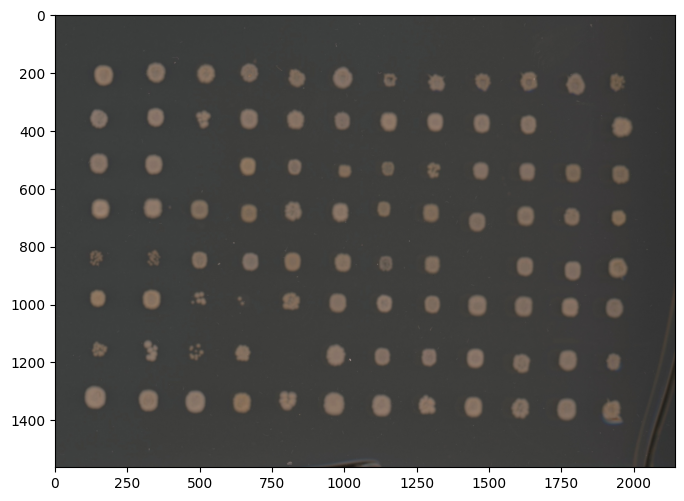

In [3]:
fig, ax = image.show()
fig.show()  # Only needed if the plot doesn't automatically show


You can always visualize your image with `Image.show()`. This returns a matplotlib figure and axes object, but should plot the figures inside a jupyter notebook. The axis labels are the pixel rows and columns that show the size of your photo. If your original input is rgb or grayscale, `Image.show()` will return the original image. To show the grayscale converted version of your image, use `Image.gray.show()`.

## Image Operations

`ImageOperations` transform the internal image data for different types of operations.

The different types of operatiosn are as follows
- `ImageCorrecter`: Transformations that improve the quality of the data, such as aligning the plate
- `ImageEnhacer`: Preprocesses the `enh_gray` property of the image, to improve detection
- `ObjectDetector`: Creates the `objmask` and `objmap` array of the image to mark where objects in the image are
- `MapModifier`: Refines the `objmask` and `objmap` of the image to make sure only the targets you want are measured

You set the parameters these operations use in the initial creation of these objects, but phenotypic now includes a useful widget to finetune these parameters.

(<Figure size 1000x500 with 2 Axes>,
 array([(<Figure size 1000x500 with 2 Axes>, <Axes: title={'center': '6_1S_8'}>),
        <Axes: >], dtype=object))

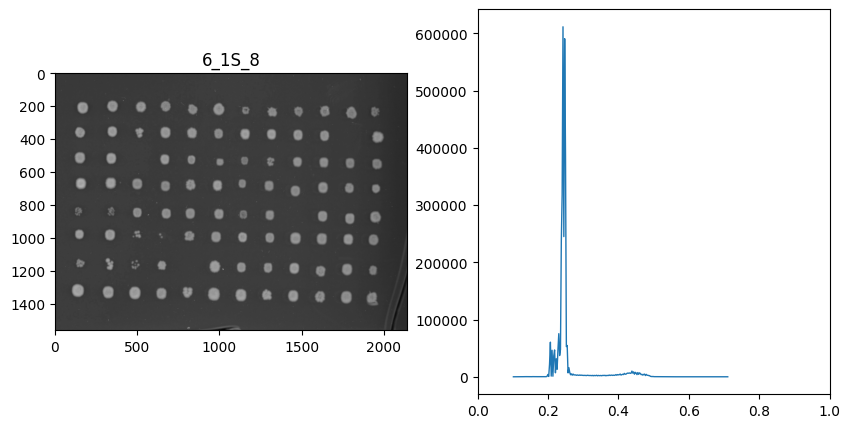

In [4]:
image.enh_gray.histogram()


This is a copy of the grayscale matrix that has not been modified yet, but will be used for detection. From the histogram, we can see the contrast is not maximized, so lets apply CLAHE (Contrast-limited adaptive histogram equalization).

(<Figure size 1000x500 with 2 Axes>,
 array([(<Figure size 1000x500 with 2 Axes>, <Axes: title={'center': '6_1S_8'}>),
        <Axes: >], dtype=object))

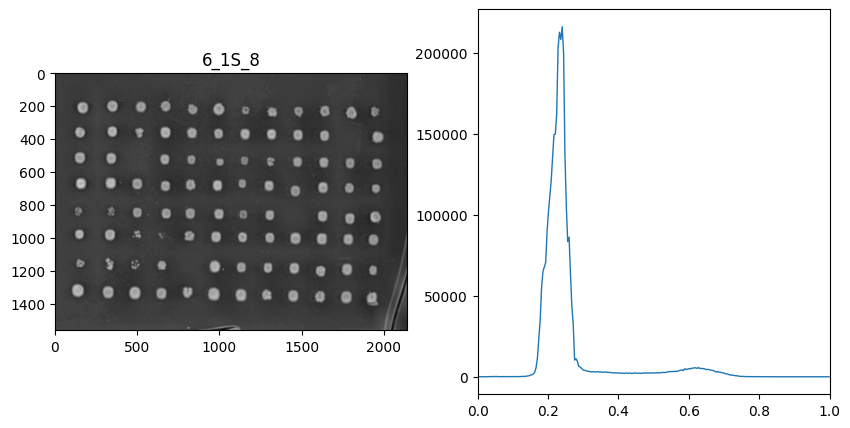

In [5]:
from phenotypic.enhance import CLAHE

enhance = CLAHE()
new_image = enhance.apply(image)
new_image.enh_gray.histogram()


Here we can see that the contrast was maximized. We can manually tune the parameters further to get different, results, but that can be somewhat cumbersome. PhenoTypic provides a widget feature when used with jupyter notebook like below to tune parameters. All `ImageOperations` and `ImagePipeline` objects have access to this. This allows us to preview parameter changes to the pipeline before we execute it.

In [6]:
enhance.widget(image)


In [7]:
print(enhance.kernel_size)


None


When we press "update view" the `CLAHE` object's internal settings change, and we can see the new results of the operation before we apply it. View the `enh_gray` image to see the changes.

## HeavyWatershedPipeline

For ease of use, PhenoTypic supplies built-in pipelines that we have curated for different projects we use internally. Here's a demo of the `HeavyWatershedPipeline`.

The HeavyWatershedPipeline consists of the following operations:
- `GaussianBlur`
- `CLAHE`
- `MedianEnhancer`
- `WatershedDetector`
- `BorderObjectRemover`
- `MinResidualErrorReducer`
- `GridAligner`
- `WatershedDetector` Note: this is applied twice since the alignment may improve the refinement results
- `MinResidualErrorReducer`
- `BorderObjectRemover`
- `MaskFill`

It also has the following measurements:
- `MeasureShape`
- `MeasureIntensity`
- `MeasureTexture`
- `MeasureColor`

You can apply `ImagePipeline` and `ImageOperation` in place or make a new copy for comparison.

```python
# return a copy
new_image = pipe.apply(image)

# in place
pipe.apply(image, inplace=True)
```

In [8]:
from phenotypic.prefab import HeavyWatershedPipeline

pipe = HeavyWatershedPipeline(border_remover_size=80)
pipe.widget(image)


/var/folders/78/rnctrlmn5kj996kjnq_mmqlh0000gn/T/ipykernel_84681/1574114370.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


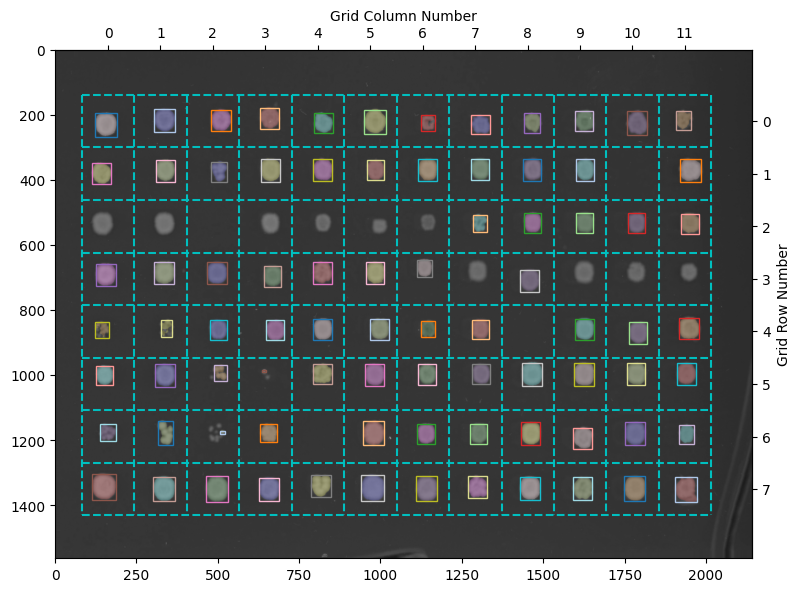

In [9]:

pipe.apply(image, inplace=True)

fig, ax = image.show_overlay()  # All operations that are plots, return a figure and axes
fig.show()


Here the objects with a colored overlay over them represent the different objects detected in your image. The boxes show the objects belonging to a specific grid section. The `HeavyWatershedPipeline` takes steps to ensure only one object in each section remains for downstream analysis. In reality, more objects were probably detected, but the refinement steps removed them according tos trict filters

Once we're happy with the pipeline you can export it for reuse:
```python
pipe.to_json("my_pipeline.json")
```

Then, you can download the phenotypic-cli.py script from the downloadables and run it in parallel with the following command:

```bash
uv run phenotypic-cli.py my_pipeline.json ./raw_images ./results --n-jobs 4
```

In [10]:
meas = pipe.measure(image)
meas.head()


,Metadata_FileSuffix,Metadata_BitDepth,Metadata_ImageType,Metadata_ImageName,ObjectLabel,Bbox_CenterRR,Bbox_CenterCC,Bbox_MinRR,Bbox_MinCC,Bbox_MaxRR,...,ColorHSV_BrightnessMin,ColorHSV_BrightnessQ1,ColorHSV_BrightnessMean,ColorHSV_BrightnessMedian,ColorHSV_BrightnessQ3,ColorHSV_BrightnessMax,ColorHSV_BrightnessStdDev,ColorHSV_BrightnessCoeffVar,ColorLab_ChromaEstimatedMean,ColorLab_ChromaEstimatedMedian
0,.jpg,8,GridImage,6_1S_8,1,210.366926,659.330741,179,630,244,...,0.313725,0.443137,0.453710,0.466667,0.478431,0.607843,0.040423,0.089125,6.153095,6.242224
1,.jpg,8,GridImage,6_1S_8,2,216.913685,336.479273,183,305,253,...,0.325490,0.454902,0.478615,0.498039,0.517647,0.552941,0.052434,0.109585,6.451107,6.766552
2,.jpg,8,GridImage,6_1S_8,3,221.064873,982.045359,184,949,258,...,0.317647,0.458824,0.479957,0.498039,0.513725,0.533333,0.045653,0.095145,5.948057,5.956704
3,.jpg,8,GridImage,6_1S_8,4,217.334898,509.347105,185,480,251,...,0.313725,0.447059,0.480092,0.501961,0.525490,0.552941,0.056078,0.116843,7.395315,7.724411
4,.jpg,8,GridImage,6_1S_8,5,218.622974,1626.595490,187,1599,251,...,0.313725,0.427451,0.452026,0.462745,0.482353,0.756863,0.040480,0.089584,7.289043,7.626104


## Processing lots of images

### Method 1. Looping through images

In [11]:
import pandas as pd
from tqdm import tqdm

batch_meas = []

# We use tqdm as a counter
# We only process 3 images for this demo
for image_path in tqdm(filepaths[:2], desc="Images", total=2):
    curr_image = pht.GridImage.imread(image_path, nrows=8, ncols=12)

    # This applies the operations and measurements at the same time
    curr_meas = pipe.apply_and_measure(curr_image, inplace=True)
    batch_meas.append(curr_meas)

batch_meas = pd.concat(batch_meas, axis=0)
batch_meas.head()


Images: 100%|██████████| 2/2 [01:24<00:00, 42.46s/it]


,Metadata_FileSuffix,Metadata_BitDepth,Metadata_ImageType,Metadata_ImageName,ObjectLabel,Bbox_CenterRR,Bbox_CenterCC,Bbox_MinRR,Bbox_MinCC,Bbox_MaxRR,...,ColorHSV_BrightnessMin,ColorHSV_BrightnessQ1,ColorHSV_BrightnessMean,ColorHSV_BrightnessMedian,ColorHSV_BrightnessQ3,ColorHSV_BrightnessMax,ColorHSV_BrightnessStdDev,ColorHSV_BrightnessCoeffVar,ColorLab_ChromaEstimatedMean,ColorLab_ChromaEstimatedMedian
0,.jpg,8,GridImage,2_1S_5,1,143.067464,639.386603,116,616,171,...,0.258824,0.290196,0.308149,0.309804,0.325490,0.360784,0.020973,0.068093,2.324545,2.412023
1,.jpg,8,GridImage,2_1S_5,2,150.576361,489.569862,122,465,182,...,0.219608,0.352941,0.377909,0.392157,0.415686,0.450980,0.049695,0.131553,2.861551,3.057672
2,.jpg,8,GridImage,2_1S_5,3,152.523276,962.444872,122,935,185,...,0.262745,0.388235,0.404418,0.419608,0.439216,0.470588,0.046826,0.115827,3.028637,3.214263
3,.jpg,8,GridImage,2_1S_5,4,153.018775,1611.383893,125,1590,183,...,0.258824,0.360784,0.389415,0.400000,0.427451,0.466667,0.045290,0.116360,4.113942,4.538226
4,.jpg,8,GridImage,2_1S_5,5,156.527308,802.681972,129,780,185,...,0.254902,0.360784,0.381683,0.396078,0.415686,0.439216,0.043488,0.113993,2.941253,3.139710


### Method 2: Joblib parallel execution

**Roadmap Update:** PhenoTypic has plans to incorporate native parallelization and processing to make this more inuitive in the future!

In [12]:
from typing import Iterator
import pandas as pd
from joblib import Parallel, delayed

pipe.dispose_widgets()  # Run this before executing in parallel


# We use a generator function to prevent loading too many images into memory
def image_iterator() -> Iterator[pht.GridImage]:
    for image_path in tqdm(filepaths[:], desc="Processing Images", total=len(filepaths)):
        yield pht.GridImage.imread(image_path, nrows=8, ncols=12)


batch_meas = Parallel(n_jobs=-1)(
        delayed(pipe.apply_and_measure)(image, inplace=False, reset=True)
        for image in image_iterator()
)

batch_meas = pd.concat(batch_meas, axis=0)
batch_meas.head()


Processing Images: 100%|██████████| 20/20 [00:00<00:00, 25.94it/s]


,Metadata_FileSuffix,Metadata_BitDepth,Metadata_ImageType,Metadata_ImageName,ObjectLabel,Bbox_CenterRR,Bbox_CenterCC,Bbox_MinRR,Bbox_MinCC,Bbox_MaxRR,...,ColorHSV_BrightnessMin,ColorHSV_BrightnessQ1,ColorHSV_BrightnessMean,ColorHSV_BrightnessMedian,ColorHSV_BrightnessQ3,ColorHSV_BrightnessMax,ColorHSV_BrightnessStdDev,ColorHSV_BrightnessCoeffVar,ColorLab_ChromaEstimatedMean,ColorLab_ChromaEstimatedMedian
0,.jpg,8,GridImage,2_1S_5,1,143.067464,639.386603,116,616,171,...,0.258824,0.290196,0.308149,0.309804,0.325490,0.360784,0.020973,0.068093,2.324545,2.412023
1,.jpg,8,GridImage,2_1S_5,2,150.576361,489.569862,122,465,182,...,0.219608,0.352941,0.377909,0.392157,0.415686,0.450980,0.049695,0.131553,2.861551,3.057672
2,.jpg,8,GridImage,2_1S_5,3,152.523276,962.444872,122,935,185,...,0.262745,0.388235,0.404418,0.419608,0.439216,0.470588,0.046826,0.115827,3.028637,3.214263
3,.jpg,8,GridImage,2_1S_5,4,153.018775,1611.383893,125,1590,183,...,0.258824,0.360784,0.389415,0.400000,0.427451,0.466667,0.045290,0.116360,4.113942,4.538226
4,.jpg,8,GridImage,2_1S_5,5,156.527308,802.681972,129,780,185,...,0.254902,0.360784,0.381683,0.396078,0.415686,0.439216,0.043488,0.113993,2.941253,3.139710


## Adding in metadata post-analysis for downstream processing

The original naming rule for this data was
`{Time}_{PlateSet}{Media}_{Replicate}`

Based on this naming rule, let's add the remaining metadata

Note: This was the original naming rule, but it leads to some awkward splitting. It's usually better to separate independent variables with underscores and related variables with dashes.


In [13]:
# We split the ImageName using string and then unpack that into three new columns in the dataframe
batch_meas[["Metadata_Time", "Metadata_SetMedia", "Metadata_Replicate"]] = \
    batch_meas["Metadata_ImageName"].str.split("_", expand=True)

# Lets now split the {PlateSet}{Media} into different columns too
batch_meas[["Metadata_PlateSet", "Metadata_Media"]] = batch_meas["Metadata_SetMedia"].str.split("", expand=True)[[1, 2]]

# Time is a number, but because we split it from its name we need to convert it to the proper datatype
batch_meas["Metadata_Time"] = batch_meas["Metadata_Time"].astype(int)
batch_meas["Metadata_PlateSet"] = batch_meas["Metadata_PlateSet"].astype(int)

# Lets see our newest changes
batch_meas[["Metadata_ImageName", "Metadata_Time", "Metadata_PlateSet", "Metadata_Media", "Metadata_Replicate"]].head()


,Metadata_ImageName,Metadata_Time,Metadata_PlateSet,Metadata_Media,Metadata_Replicate
0,2_1S_5,2,1,S,5
1,2_1S_5,2,1,S,5
2,2_1S_5,2,1,S,5
3,2_1S_5,2,1,S,5
4,2_1S_5,2,1,S,5


## Adding in metadata like strain name

To add in metadata like the strain name for each column to your data, we'll use table joining.



In [14]:
# Lets generate a synthetic table of strain names
import pandas as pd

# It's important to use the same names as the measurement dataframe
synth_names = pd.DataFrame(data={
    "Metadata_PlateSet"  : 1,
    "Grid_SectionNum"    : range(96),
    "Metadata_StrainName": [f"SYNTH-{idx:02d}" for idx in range(96)],
})

synth_names


,Metadata_PlateSet,Grid_SectionNum,Metadata_StrainName
0,1,0,SYNTH-00
1,1,1,SYNTH-01
2,1,2,SYNTH-02
3,1,3,SYNTH-03
4,1,4,SYNTH-04
...,...,...,...
91,1,91,SYNTH-91
92,1,92,SYNTH-92
93,1,93,SYNTH-93
94,1,94,SYNTH-94


In [15]:
meas = batch_meas.merge(synth_names, on=["Metadata_PlateSet", "Grid_SectionNum"], how="inner")
meas[["Metadata_PlateSet", "Grid_SectionNum", "Metadata_StrainName", "Shape_Area"]].head()


,Metadata_PlateSet,Grid_SectionNum,Metadata_StrainName,Shape_Area
0,1,3,SYNTH-03,2090.0
1,1,2,SYNTH-02,2462.0
2,1,5,SYNTH-05,2857.0
3,1,9,SYNTH-09,2024.0
4,1,4,SYNTH-04,2069.0


We'll also use this data in the {doc}`GrowthCurves`.